# DTDR "Hadamard-Tree" Routing Proof-of-Concept (IVF list selection)

This notebook is a **stand-alone proof of concept** for the routing idea we intended by "dilution":

- Build an IVF index (k-means centroids + list assignment)
- For each IVF list, precompute a **multi-level hierarchical dilution signature**:
  - level ℓ corresponds to mixing groups of size g = 2^ℓ
  - per level we store a small number of **sketch vectors** (random ±1 mixing within groups)
- At query time, for each candidate list we compute a **signal vector** s = [s0, s1, ..., sL]
  - where sℓ is the max similarity between the query and that list’s sketches at level ℓ
- Learn a lightweight model (logistic regression) to map s → probability(list contains true NN)
- Compare list-selection vs centroid-only routing at the same nprobe

Key point: this is **NOT** scanning all lists with sampling per query. The per-list hierarchy is **precomputed**.

If SIFT1M is available locally, we use it. Otherwise we fall back to a synthetic dataset.


In [1]:
# ---- Minimal dependencies (install if missing) ----
import sys, subprocess

def ensure(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in ["numpy", "scikit-learn", "matplotlib"]:
    try:
        __import__(pkg.replace('-', '_'))
    except Exception:
        ensure(pkg)

print("OK: dependencies present")


OK: dependencies present


In [2]:
import os, time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

SEED = 42
rng = np.random.default_rng(SEED)
np.random.seed(SEED)

SIFT_DIR = r"G:\train_jw\datasets\sift1m"

print("OK: imports")


OK: imports


## Configuration

Set `SIFT_DIR` to your local SIFT1M folder (or leave blank to use synthetic data).

Typical SIFT1M filenames:
- sift_base.fvecs
- sift_query.fvecs
- sift_groundtruth.ivecs


In [3]:
# ---- Paths ----
SIFT_DIR = r"G:\train_jw\datasets\sift1m"

# ---- Dataset sizing (for speed) ----
USE_SIFT_IF_AVAILABLE = True
BASE_LIMIT = 200_000      # set to 1_000_000 for full SIFT1M
QUERY_LIMIT = 2_000       # number of queries to evaluate

# ---- IVF settings ----
NLIST = 256
NPROBE = 1
CENTROID_SHORTLIST_M = 16   # shortlist lists by centroid, then apply micro-dilution score

# ---- Micro-dilution (LEVEL-1 only) ----
# We keep ONLY the level-1 pairwise sum signatures; no deep hierarchy.
PAIR_CAP_PER_LIST = 256     # max number of base vectors per IVF list to use for signatures
PAIR_MODE = "random"        # "random" or "first" pairing
PAIR_SCORE = "topk_mean"    # "max" or "topk_mean"
PAIR_TOPK = 8               # used if PAIR_SCORE == "topk_mean"

# ---- Search evaluation ----
TOPK = 1

print("Config loaded (micro-dilution level-1)")

Config loaded (micro-dilution level-1)


In [4]:
import os, platform

print("Platform:", platform.platform())
print("CWD:", os.getcwd())
print("SIFT_DIR:", SIFT_DIR)

for fn in ["sift_base.fvecs","sift_query.fvecs","sift_groundtruth.ivecs","sift_base.npy","sift_query.npy"]:
    p = os.path.join(SIFT_DIR, fn)
    print(f"exists {fn}:", os.path.exists(p), " -> ", p)

Platform: Windows-10-10.0.26200-SP0
CWD: G:\train_jw\experiments\02_dtdr_end_to_end_search
SIFT_DIR: G:\train_jw\datasets\sift1m
exists sift_base.fvecs: True  ->  G:\train_jw\datasets\sift1m\sift_base.fvecs
exists sift_query.fvecs: True  ->  G:\train_jw\datasets\sift1m\sift_query.fvecs
exists sift_groundtruth.ivecs: True  ->  G:\train_jw\datasets\sift1m\sift_groundtruth.ivecs
exists sift_base.npy: True  ->  G:\train_jw\datasets\sift1m\sift_base.npy
exists sift_query.npy: True  ->  G:\train_jw\datasets\sift1m\sift_query.npy


## Helpers: fvecs/ivecs loader (SIFT1M)

These readers handle the classic ANN benchmark file formats.


In [5]:
def read_fvecs(path, limit=None):
    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.int32)
    d = data[0]
    data = data.reshape(-1, d + 1)
    vecs = data[:, 1:].view(np.float32)
    if limit is not None:
        vecs = vecs[:limit]
    return vecs

def read_ivecs(path, limit=None):
    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.int32)
    d = data[0]
    data = data.reshape(-1, d + 1)
    ivecs = data[:, 1:]
    if limit is not None:
        ivecs = ivecs[:limit]
    return ivecs

def l2_normalize(X, eps=1e-12):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.maximum(norms, eps)

print("OK: loaders")


OK: loaders


## Load dataset (SIFT if present; else synthetic)

For routing and list-selection evaluation, we use cosine similarity on L2-normalized vectors.
SIFT is traditionally evaluated with L2 distance, but cosine on normalized vectors is fine for this POC.


In [6]:
def load_data():
    """Load SIFT1M if present; prefer .npy; fall back to .fvecs; else synthetic."""
    if USE_SIFT_IF_AVAILABLE and SIFT_DIR:
        base_npy  = os.path.join(SIFT_DIR, "sift_base.npy")
        query_npy = os.path.join(SIFT_DIR, "sift_query.npy")
        gt_path   = os.path.join(SIFT_DIR, "sift_groundtruth.ivecs")

        base_fvec = os.path.join(SIFT_DIR, "sift_base.fvecs")
        query_fvec= os.path.join(SIFT_DIR, "sift_query.fvecs")

        has_gt   = os.path.exists(gt_path)
        has_npy  = os.path.exists(base_npy) and os.path.exists(query_npy)
        has_fvec = os.path.exists(base_fvec) and os.path.exists(query_fvec)

        print("SIFT check:")
        print("  has_gt  :", has_gt,  gt_path)
        print("  has_npy :", has_npy, base_npy, query_npy)
        print("  has_fvec:", has_fvec, base_fvec, query_fvec)

        if has_gt and (has_npy or has_fvec):
            print("Loading SIFT1M from:", SIFT_DIR)
            if has_npy:
                print("  Using .npy (mmap) for base/query")
                X = np.load(base_npy, mmap_mode="r")
                Q = np.load(query_npy, mmap_mode="r")
                X = np.asarray(X[:BASE_LIMIT], dtype=np.float32)
                Q = np.asarray(Q[:QUERY_LIMIT], dtype=np.float32)
            else:
                print("  Using .fvecs for base/query")
                X = read_fvecs(base_fvec, limit=BASE_LIMIT).astype(np.float32)
                Q = read_fvecs(query_fvec, limit=QUERY_LIMIT).astype(np.float32)

            GT = read_ivecs(gt_path, limit=QUERY_LIMIT)
            print("Loaded:")
            print("  X:", X.shape, "Q:", Q.shape, "GT:", GT.shape)
            return X, Q, GT

        else:
            raise FileNotFoundError(
                "SIFT_DIR is set but required files were not found. "
                "Check sift_base/query (.npy or .fvecs) and sift_groundtruth.ivecs."
            )

    print("SIFT not enabled or SIFT_DIR unset. Using synthetic data.")
    n = min(BASE_LIMIT, 200_000)
    d = 128
    q = min(QUERY_LIMIT, 2_000)
    X = rng.standard_normal((n, d)).astype(np.float32)
    Q = rng.standard_normal((q, d)).astype(np.float32)
    GT = None
    return X, Q, GT


X_fp, Q_fp, GT = load_data()
X = l2_normalize(X_fp)
Q = l2_normalize(Q_fp)
n, d = X.shape
q = Q.shape[0]
print("X:", X.shape, "Q:", Q.shape)

SIFT check:
  has_gt  : True G:\train_jw\datasets\sift1m\sift_groundtruth.ivecs
  has_npy : True G:\train_jw\datasets\sift1m\sift_base.npy G:\train_jw\datasets\sift1m\sift_query.npy
  has_fvec: True G:\train_jw\datasets\sift1m\sift_base.fvecs G:\train_jw\datasets\sift1m\sift_query.fvecs
Loading SIFT1M from: G:\train_jw\datasets\sift1m
  Using .npy (mmap) for base/query
Loaded:
  X: (200000, 128) Q: (2000, 128) GT: (2000, 100)
X: (200000, 128) Q: (2000, 128)


In [7]:
# --- Cosine-consistent ground truth for this subset ---
# We compute GT_cosine for Q against X using dot products on normalized vectors.
# This replaces SIFT's provided L2 ground truth for evaluation in cosine space.

def cosine_gt_topk(X, Q, topk=10, chunk=20000):
    # returns indices (q, topk)
    qn = Q.shape[0]
    best_idx = np.zeros((qn, topk), dtype=np.int64)
    best_sim = np.full((qn, topk), -np.inf, dtype=np.float32)

    for start in range(0, X.shape[0], chunk):
        Xc = X[start:start+chunk]          # (chunk, d)
        sims = Q @ Xc.T                    # (q, chunk)

        # candidate indices in this chunk
        idx = np.argpartition(-sims, kth=topk-1, axis=1)[:, :topk]
        sim = np.take_along_axis(sims, idx, axis=1)

        # merge with global best
        merged_sim = np.concatenate([best_sim, sim], axis=1)
        merged_idx = np.concatenate([best_idx, idx + start], axis=1)

        sel = np.argpartition(-merged_sim, kth=topk-1, axis=1)[:, :topk]
        best_sim = np.take_along_axis(merged_sim, sel, axis=1)
        best_idx = np.take_along_axis(merged_idx, sel, axis=1)

    # sort topk
    order = np.argsort(-best_sim, axis=1)
    best_idx = np.take_along_axis(best_idx, order, axis=1)
    return best_idx.astype(np.int32)

print("Computing cosine-consistent ground truth...")
t0 = time.time()
GT_cos = cosine_gt_topk(X, Q, topk=TOPK, chunk=20000)
print("Done in %.2fs" % (time.time()-t0))

Computing cosine-consistent ground truth...
Done in 2.02s


In [8]:
base_npy = os.path.join(SIFT_DIR, "sift_base.npy")
query_npy = os.path.join(SIFT_DIR, "sift_query.npy")

if os.path.exists(base_npy) and os.path.exists(query_npy):
    X = np.load(base_npy, mmap_mode="r")
    Q = np.load(query_npy, mmap_mode="r")
else:
    X = read_fvecs(base_path, limit=BASE_LIMIT)
    Q = read_fvecs(query_path, limit=QUERY_LIMIT)

## Build IVF (k-means centroids + assignment)

We use MiniBatchKMeans for speed.


In [9]:
t0 = time.time()
kmeans = MiniBatchKMeans(n_clusters=NLIST, random_state=SEED, batch_size=8192, n_init=3, max_iter=100)
kmeans.fit(X)
C = l2_normalize(kmeans.cluster_centers_.astype(np.float32))
assign = kmeans.predict(X)

lists = [[] for _ in range(NLIST)]
for i, lid in enumerate(assign):
    lists[lid].append(i)

list_sizes = np.array([len(lst) for lst in lists], dtype=np.int32)
print("Built IVF:")
print("  NLIST:", NLIST)
print("  mean list size:", float(list_sizes.mean()))
print("  max list size:", int(list_sizes.max()))
print("  build time: %.2fs" % (time.time() - t0))


Built IVF:
  NLIST: 256
  mean list size: 3906.25
  max list size: 9276
  build time: 17.05s


In [10]:
# ============================================================
# Routing helpers (centroid shortlist + micro-dilution features)
# ============================================================

def centroid_shortlist(C, q, M=32):
    """
    Return the top-M IVF list IDs by cosine similarity to centroids.
    Assumes C and q are L2-normalized.
    """
    sims = C @ q
    idx = np.argpartition(-sims, kth=M-1)[:M]
    idx = idx[np.argsort(-sims[idx])]
    return idx


def micro_dilution_features_level1(signatures, q, lids, score_mode="topk_mean", topk=8):
    """
    For each candidate list lid, compute a single micro-dilution score based on
    LEVEL-1 pairwise sum signatures stored in signatures[lid] (shape: (pairs, d)).

    Returns: feats of shape (len(lids), 1)
    """
    feats = np.zeros((len(lids), 1), dtype=np.float32)

    for i, lid in enumerate(lids):
        S = signatures[lid]
        if S is None or S.shape[0] == 0:
            feats[i, 0] = -1.0
            continue

        sims = S @ q  # (pairs,)
        if score_mode == "max":
            feats[i, 0] = float(np.max(sims))
        else:
            k = min(topk, sims.shape[0])
            idx = np.argpartition(-sims, kth=k-1)[:k]
            feats[i, 0] = float(np.mean(sims[idx]))

    return feats


print("OK: centroid_shortlist + micro_dilution_features_level1 are defined")

OK: centroid_shortlist + micro_dilution_features_level1 are defined


## Build hierarchical dilution signatures per list

We precompute a small number of sketch vectors per list per level.

- Level ℓ corresponds to group size g = 2^ℓ
- Each sketch is a random ±1 mixing within a sampled group (a Hadamard-like mixing step)
- This produces a per-list multi-level signal sℓ at query time

This is the key distinction vs the previous expensive approach: **no per-query scanning of all list members**.


In [11]:
def build_list_signatures_level1(X, lists, cap_per_list=256, sketches_per_level=None, seed=42, mode="random"):
    """
    Build LEVEL-1 (pairwise sum) signatures per list.

    For each list:
      - take up to cap_per_list vectors (random subset or first)
      - form pairs and compute normalized sums (x_i + x_j)
      - store those as signatures[lid] with shape (num_pairs, d)

    Notes:
      - This is the "micro-dilution" signal (group size 2).
      - No deeper levels are computed.
    """
    rng_local = np.random.default_rng(seed)
    nlist = len(lists)
    d = X.shape[1]
    signatures = [None for _ in range(nlist)]

    for lid, idxs in enumerate(lists):
        m = len(idxs)
        if m < 2:
            signatures[lid] = np.zeros((0, d), dtype=np.float32)
            continue

        idxs = np.array(idxs, dtype=np.int64)

        # choose up to cap_per_list items from this list
        if m > cap_per_list:
            if mode == "random":
                pick = rng_local.choice(m, size=cap_per_list, replace=False)
                sel = idxs[pick]
            else:  # "first"
                sel = idxs[:cap_per_list]
        else:
            sel = idxs

        V = X[sel]  # (m_cap, d)
        m_cap = V.shape[0]

        # if odd, drop one
        if (m_cap % 2) == 1:
            V = V[:-1]
            m_cap -= 1

        # pairing
        if mode == "random":
            perm = rng_local.permutation(m_cap)
            Vp = V[perm]
        else:
            Vp = V

        A = Vp[0::2]
        B = Vp[1::2]
        S = A + B                       # (m_cap/2, d)
        S = l2_normalize(S)             # normalize sums
        signatures[lid] = S.astype(np.float32)

    return signatures


t0 = time.time()
signatures = build_list_signatures_level1(
    X, lists,
    cap_per_list=PAIR_CAP_PER_LIST,
    seed=SEED,
    mode=PAIR_MODE
)
print("Built LEVEL-1 signatures in %.2fs" % (time.time() - t0))

# quick sanity print
lens = np.array([sig.shape[0] for sig in signatures], dtype=np.int32)
print("Signatures per list: mean pairs =", float(lens.mean()), "max pairs =", int(lens.max()))

Built LEVEL-1 signatures in 0.14s
Signatures per list: mean pairs = 128.0 max pairs = 128


## Ground truth (if needed)

- For SIFT1M, we use provided ground truth.
- For synthetic fallback, we compute ground truth by brute force on a smaller subset.


In [12]:
# ============================================================
# Ground truth (cosine-consistent)
# ============================================================
# We evaluate routing + search using cosine similarity on L2-normalized vectors.
# Therefore we must compute GT in the same metric.
#
# Even if SIFT provides L2 ground truth, it is NOT consistent with cosine-on-normalized
# evaluation. We'll compute a cosine-consistent GT for our subset and overwrite GT.
# ============================================================

def cosine_gt_topk(X, Q, topk=10, chunk=20000):
    """
    Compute cosine-sim topk neighbors for each query in Q against base X.
    Assumes X and Q are already L2-normalized. Uses chunking to limit memory.
    Returns int32 indices of shape (q, topk).
    """
    qn = Q.shape[0]
    best_idx = np.zeros((qn, topk), dtype=np.int64)
    best_sim = np.full((qn, topk), -np.inf, dtype=np.float32)

    for start in range(0, X.shape[0], chunk):
        Xc = X[start:start+chunk]          # (chunk, d)
        sims = Q @ Xc.T                    # (q, chunk)

        # topk within chunk
        idx = np.argpartition(-sims, kth=topk-1, axis=1)[:, :topk]
        sim = np.take_along_axis(sims, idx, axis=1)

        # merge with global best
        merged_sim = np.concatenate([best_sim, sim], axis=1)
        merged_idx = np.concatenate([best_idx, idx + start], axis=1)

        sel = np.argpartition(-merged_sim, kth=topk-1, axis=1)[:, :topk]
        best_sim = np.take_along_axis(merged_sim, sel, axis=1)
        best_idx = np.take_along_axis(merged_idx, sel, axis=1)

    # sort final topk
    order = np.argsort(-best_sim, axis=1)
    best_idx = np.take_along_axis(best_idx, order, axis=1)

    return best_idx.astype(np.int32)


print("Computing cosine-consistent ground truth (this replaces SIFT L2 GT for evaluation)...")
t0 = time.time()
GT = cosine_gt_topk(X, Q, topk=TOPK, chunk=20000)  # <-- OVERWRITE GT
print("Done in %.2fs" % (time.time() - t0))
print("GT (cosine) shape:", GT.shape)

# Ground-truth nearest-neighbor id (for labeling lists)
gt_nn = GT[:, 0].astype(np.int64)
gt_list = assign[gt_nn]

print("GT metric: cosine-consistent (dot product on L2-normalized vectors)")
print("OK: GT ready")

Computing cosine-consistent ground truth (this replaces SIFT L2 GT for evaluation)...
Done in 50.70s
GT (cosine) shape: (10000, 1)
GT metric: cosine-consistent (dot product on L2-normalized vectors)
OK: GT ready


## Feature extraction: hierarchical dilution signal per candidate list

For a query q and list lid:

- For each level ℓ, compute sℓ = max_j (q · signature[lid][ℓ][j])

This produces a feature vector of length `LEVELS`.


In [13]:
def micro_dilution_features_level1(signatures, q, lids, score_mode="topk_mean", topk=8):
    """
    For each candidate list lid, compute a single micro-dilution score based on LEVEL-1 pairwise sums.

    score_mode:
      - "max":        max dot(q, sig)
      - "topk_mean":  mean of top-k dot(q, sig)  (more stable)

    Returns: feats (len(lids), 1)
    """
    feats = np.zeros((len(lids), 1), dtype=np.float32)

    for i, lid in enumerate(lids):
        S = signatures[lid]   # (pairs, d)
        if S.shape[0] == 0:
            feats[i, 0] = -1.0
            continue

        sims = S @ q  # (pairs,)
        if score_mode == "max":
            feats[i, 0] = float(np.max(sims))
        else:
            k = min(topk, sims.shape[0])
            idx = np.argpartition(-sims, kth=k-1)[:k]
            feats[i, 0] = float(np.mean(sims[idx]))

    return feats


print("OK: micro-dilution feature func ready")

OK: micro-dilution feature func ready


## Train a simple routing model (logistic regression)

We build training examples from queries:

- candidate lists = centroid shortlist (M)
- features = dilution signal across levels
- label = 1 if candidate list contains the true NN, else 0

Then at query time:

- shortlist by centroids
- score candidates by model probability
- take top nprobe lists


In [14]:
def make_training_data(Q, gt_list, C, signatures, M=32, max_train=1000):
    ntrain = min(Q.shape[0], max_train)
    Xtr, ytr = [], []
    for qi in range(ntrain):
        qv = Q[qi]
        cand = centroid_shortlist(C, qv, M=M)
        feats = micro_dilution_features_level1(
            signatures, qv, cand,
            score_mode=PAIR_SCORE,
            topk=PAIR_TOPK
        )
        labels = (cand == gt_list[qi]).astype(np.int32)
        Xtr.append(feats)
        ytr.append(labels)
    Xtr = np.vstack(Xtr)
    ytr = np.concatenate(ytr)
    return Xtr, ytr

t0 = time.time()
Xtr, ytr = make_training_data(Q, gt_list, C, signatures, M=CENTROID_SHORTLIST_M, max_train=min(1000, q))

model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, random_state=SEED))
])
model.fit(Xtr, ytr)

print("Training examples:", Xtr.shape, "positives:", int(ytr.sum()))
print("Trained logistic model in %.2fs" % (time.time() - t0))


Training examples: (16000, 1) positives: 991
Trained logistic model in 1.87s


## Evaluate routing: centroid-only vs dilution-model routing

To keep this POC focused on list selection, we do:

- list selection (nprobe)
- then exact cosine search within union of selected lists
- compute recall@K vs ground truth

We report latency as Python time for the whole routing+search loop.


In [15]:
def search_within_lists(X, q, lists, lids, topk=10):
    # Gather candidate indices
    cand_ids = []
    for lid in lids:
        cand_ids.extend(lists[lid])
    if len(cand_ids) == 0:
        return np.array([], dtype=np.int64)
    cand_ids = np.array(cand_ids, dtype=np.int64)
    sims = X[cand_ids] @ q
    k = min(topk, sims.shape[0])
    idx = np.argpartition(-sims, kth=k-1)[:k]
    idx = idx[np.argsort(-sims[idx])]
    return cand_ids[idx]

def recall_at_k(results, gt, k=10):
    # results: list of arrays of retrieved ids; gt: (q, topk)
    hits = 0
    for i, r in enumerate(results):
        if len(r) == 0:
            continue
        gt_set = set(gt[i, :k].tolist())
        if any(int(x) in gt_set for x in r[:k]):
            hits += 1
    return hits / len(results)

def eval_routing(Q, GT, C, X, lists, signatures, model, nprobe=4, M=32, topk=10, max_eval=2000):
    neval = min(Q.shape[0], max_eval)
    res_centroid = []
    res_dilution = []

    t_centroid = 0.0
    t_dilution = 0.0

    for i in range(neval):
        qv = Q[i]

        # --- centroid-only routing ---
        t0 = time.time()
        cand = centroid_shortlist(C, qv, M=M)
        lids = cand[:nprobe]
        r = search_within_lists(X, qv, lists, lids, topk=topk)
        t_centroid += (time.time() - t0)
        res_centroid.append(r)

        # --- dilution-model routing ---
        t0 = time.time()
        cand = centroid_shortlist(C, qv, M=M)
        feats = micro_dilution_features_level1(
            signatures, qv, cand,
            score_mode=PAIR_SCORE,
            topk=PAIR_TOPK
        )
        probs = model.predict_proba(feats)[:, 1]
        lids = cand[np.argsort(-probs)[:nprobe]]
        r = search_within_lists(X, qv, lists, lids, topk=topk)
        t_dilution += (time.time() - t0)
        res_dilution.append(r)

    r1 = recall_at_k(res_centroid, GT, k=topk)
    r2 = recall_at_k(res_dilution, GT, k=topk)

    return {
        "neval": neval,
        "recall@%d_centroid" % topk: r1,
        "recall@%d_dilution" % topk: r2,
        "mean_ms_centroid": (t_centroid / neval) * 1000.0,
        "mean_ms_dilution": (t_dilution / neval) * 1000.0,
        "overhead_ms": ((t_dilution - t_centroid) / neval) * 1000.0
    }

t0 = time.time()
metrics = eval_routing(
    Q, GT, C, X, lists, signatures, model,
    nprobe=NPROBE,
    M=CENTROID_SHORTLIST_M,
    topk=TOPK,
    max_eval=min(2000, q)
)
print("Eval time: %.2fs" % (time.time() - t0))
print("NOTE: Evaluation uses cosine-consistent GT computed in this notebook.")
metrics


Eval time: 10.48s
NOTE: Evaluation uses cosine-consistent GT computed in this notebook.


{'neval': 2000,
 'recall@1_centroid': 0.4865,
 'recall@1_dilution': 0.4915,
 'mean_ms_centroid': 1.5904666185379028,
 'mean_ms_dilution': 3.637779116630554,
 'overhead_ms': 2.0473124980926514}

In [16]:
def list_hit_rate(Q, gt_list, C, signatures, model, nprobe=1, M=16, mode="centroid",
                  score_mode="topk_mean", topk=8):
    """
    List routing hit-rate:
      returns fraction of queries for which the true-NN list (gt_list[i]) is contained
      in the selected nprobe lists.

    mode:
      - "centroid": choose top-nprobe by centroid similarity
      - "dilution": choose top-nprobe by micro-dilution model probabilities over centroid shortlist
    """
    hits = 0
    for i in range(Q.shape[0]):
        qv = Q[i]
        cand = centroid_shortlist(C, qv, M=M)

        if mode == "centroid":
            chosen = cand[:nprobe]
        else:
            feats = micro_dilution_features_level1(
                signatures, qv, cand,
                score_mode=score_mode,
                topk=topk
            )
            probs = model.predict_proba(feats)[:, 1]
            chosen = cand[np.argsort(-probs)[:nprobe]]

        if gt_list[i] in chosen:
            hits += 1

    return hits / Q.shape[0]


# --- run it on the same number of eval queries ---
neval = metrics["neval"]

hr_cent = list_hit_rate(
    Q[:neval], gt_list[:neval],
    C, signatures, model,
    nprobe=NPROBE, M=CENTROID_SHORTLIST_M,
    mode="centroid",
    score_mode=PAIR_SCORE, topk=PAIR_TOPK
)

hr_dilu = list_hit_rate(
    Q[:neval], gt_list[:neval],
    C, signatures, model,
    nprobe=NPROBE, M=CENTROID_SHORTLIST_M,
    mode="dilution",
    score_mode=PAIR_SCORE, topk=PAIR_TOPK
)

print("List hit-rate (true NN list in selected nprobe):")
print(" centroid:", hr_cent)
print(" dilution :", hr_dilu)

List hit-rate (true NN list in selected nprobe):
 centroid: 0.4865
 dilution : 0.4915


## Visual summary

We plot recall and query-time comparison.


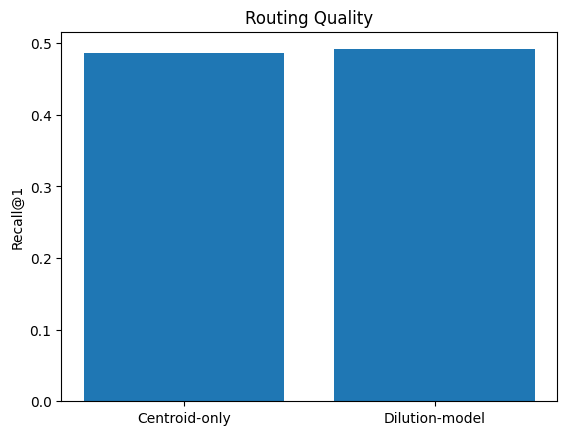

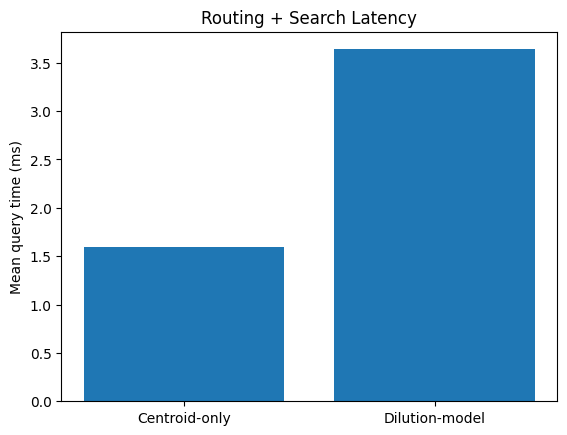

Overhead (ms/query): 2.0473124980926514


In [17]:
labels = ["Centroid-only", "Dilution-model"]
recalls = [metrics[f"recall@{TOPK}_centroid"], metrics[f"recall@{TOPK}_dilution"]]
times = [metrics["mean_ms_centroid"], metrics["mean_ms_dilution"]]

plt.figure()
plt.bar(labels, recalls)
plt.ylabel(f"Recall@{TOPK}")
plt.title("Routing Quality")
plt.show()

plt.figure()
plt.bar(labels, times)
plt.ylabel("Mean query time (ms)")
plt.title("Routing + Search Latency")
plt.show()

print("Overhead (ms/query):", metrics["overhead_ms"])


## Interpretation

If this POC works as intended, you should see:

- Dilution-model routing improves Recall@K vs centroid-only at the same nprobe
- Overhead is modest because signatures are precomputed and we only score a centroid shortlist (M)

If overhead is still large:

- reduce LEVELS
- reduce SKETCHES_PER_LEVEL
- reduce CENTROID_SHORTLIST_M

If recall gain is small:

- increase SKETCHES_PER_LEVEL
- increase CENTROID_SHORTLIST_M
- increase training queries (max_train)


In [18]:
import numpy as np

def l2norm(X, eps=1e-12):
    n = np.linalg.norm(X, axis=-1, keepdims=True)
    return X / np.maximum(n, eps)

def next_pow2(n):
    return 1 if n <= 1 else 2**int(np.ceil(np.log2(n)))

def pad_to_pow2(V):
    m, d = V.shape
    M = next_pow2(m)
    if M == m:
        return V
    pad = np.zeros((M - m, d), dtype=V.dtype)
    return np.vstack([V, pad])

def hadamard_sum_tree(V):
    """
    Build sum-channel hierarchy.
    Returns levels: list of arrays, levels[0] shape (M,d), levels[1] shape (M/2,d), ..., root shape (1,d)
    """
    V = pad_to_pow2(V)
    levels = [V]
    cur = V
    while cur.shape[0] > 1:
        cur = (cur[0::2] + cur[1::2]) / np.sqrt(2.0)
        levels.append(cur)
    return levels

def signal_curve(levels, q):
    """s_l = max dot(q, node) for each level l."""
    s = []
    for L in levels:
        s.append(float(np.max(L @ q)))
    return np.array(s, dtype=np.float32)

def tree_traverse(levels, q):
    """
    Coarse-to-fine:
    start at root index 0, at each level choose best child among two children.
    Returns leaf index in padded array.
    """
    idx = 0
    # levels[-1] is root (1 node). descend back to level 0
    for ell in range(len(levels)-2, -1, -1):
        # at level ell, children indices are 2*idx and 2*idx+1
        c0 = 2*idx
        c1 = 2*idx + 1
        L = levels[ell]
        # compare dot products
        if (L[c1] @ q) > (L[c0] @ q):
            idx = c1
        else:
            idx = c0
    return idx

# How well can we select the right list WITHOUT level-0?
def hit_rate_using_levels(level_idxs):
    hits = 0
    for t in range(trials):
        target_list = rng.integers(0, N_lists)
        target_i = rng.integers(0, m)
        v = lists[target_list][target_i]
        q = l2norm((v + 0.10*rng.standard_normal(d).astype(np.float32))[None, :])[0]
        trees = [hadamard_sum_tree(L) for L in lists]
        scores = np.stack([signal_curve(trees[li], q) for li in range(N_lists)], axis=0)

        # weighted sum over chosen levels
        s = scores[:, level_idxs].sum(axis=1)
        chosen = int(np.argmax(s))
        hits += (chosen == target_list)
    return hits / trials

print("List hit using only root level:", hit_rate_using_levels([-1]))
print("List hit using levels 1..end (exclude level-0):", hit_rate_using_levels(list(range(1, scores.shape[1]))))
print("List hit using mid+coarse levels (3..end):", hit_rate_using_levels(list(range(3, scores.shape[1]))))

# ---- Toy experiment ----
rng = np.random.default_rng(0)

N_lists = 64     # number of lists
m = 128          # vectors per list (power of 2 preferred)
d = 128          # dimension
trials = 500

# build random lists
lists = [l2norm(rng.standard_normal((m, d)).astype(np.float32)) for _ in range(N_lists)]

hit_traverse = 0
hit_bestleaf = 0

# collect example signal curves for plotting/inspection
curves_pos = []
curves_neg = []

for t in range(trials):
    # choose a target list and a target vector in it
    target_list = rng.integers(0, N_lists)
    target_i = rng.integers(0, m)

    # define query as noisy version of that target vector
    v = lists[target_list][target_i]
    q = l2norm((v + 0.10*rng.standard_normal(d).astype(np.float32))[None, :])[0]

    # build trees for each list (small m so ok)
    trees = [hadamard_sum_tree(L) for L in lists]

    # compute signal curves
    scores = []
    for li in range(N_lists):
        s = signal_curve(trees[li], q)
        scores.append(s)
        if li == target_list:
            curves_pos.append(s)
        else:
            # store a few negatives for comparison
            if len(curves_neg) < len(curves_pos):
                curves_neg.append(s)

    scores = np.stack(scores, axis=0)  # (N_lists, levels)


    
    # list selection based on curve (simple heuristic): use finest-level max (level 0) OR weighted combo
    # start with simplest: best s_0 (level 0) -- this is basically exact max in list.
    chosen_list_bestleaf = int(np.argmax(scores[:, 0]))
    if chosen_list_bestleaf == target_list:
        hit_bestleaf += 1

    # tree traversal selection:
    # choose list by root similarity, then traverse inside chosen list
    chosen_list_root = int(np.argmax(scores[:, -1]))  # most diluted
    leaf = tree_traverse(trees[chosen_list_root], q)

    if chosen_list_root == target_list and leaf == target_i:
        hit_traverse += 1

print("Trials:", trials)
print("List chosen by level-0 max hit-rate:", hit_bestleaf / trials)
print("Full traversal exact-leaf success:", hit_traverse / trials)

# average curves
pos_mean = np.mean(np.stack(curves_pos), axis=0)
neg_mean = np.mean(np.stack(curves_neg), axis=0)

print("Mean signal curve (pos):", pos_mean)
print("Mean signal curve (neg):", neg_mean)
print("Δ curve (pos-neg):", pos_mean - neg_mean)

NameError: name 'trials' is not defined

In [ ]:
# ============================================================
# Shallow-level routing tests for Hadamard sum-tree "dilution"
# ============================================================
# Goal:
#   Measure how well we can pick the correct list WITHOUT scanning level-0.
#
# We test:
#   - root only
#   - each level alone (1,2,3,...)
#   - combinations (1+2), (1+2+3), (1..end), (3..end)
#
# Interpretation:
#   If (1+2) is strong, then "micro-dilution" is the useful signal,
#   not deep hierarchy / root-level dilution.
# ============================================================

import numpy as np

def list_hit_rate_using_levels(level_idxs, noise=0.10, trials=500):
    hits = 0
    # build trees once per trial set? (trees depend on lists only, so prebuild outside loop for speed)
    trees = [hadamard_sum_tree(L) for L in lists]
    Lcount = len(trees[0])  # number of levels

    # normalize/validate indices
    level_idxs = [li if li >= 0 else (Lcount + li) for li in level_idxs]
    assert all(0 <= li < Lcount for li in level_idxs), (level_idxs, Lcount)

    for t in range(trials):
        target_list = rng.integers(0, N_lists)
        target_i = rng.integers(0, m)
        v = lists[target_list][target_i]
        q = l2norm((v + noise * rng.standard_normal(d).astype(np.float32))[None, :])[0]

        # score each list by sum of selected levels
        scores = np.zeros((N_lists,), dtype=np.float32)
        for li in range(N_lists):
            s = signal_curve(trees[li], q)   # shape (levels,)
            scores[li] = float(np.sum(s[level_idxs]))

        chosen = int(np.argmax(scores))
        hits += (chosen == target_list)

    return hits / trials


# ---- Run suite of shallow-level tests ----
print("=== Shallow-level routing tests (Hadamard sum-tree) ===")
print(f"N_lists={N_lists}, m={m}, d={d}, trials={trials}")

# Root only
hr_root = list_hit_rate_using_levels([-1], trials=trials)
print("List hit using only root level (-1):", hr_root)

# Levels 1..end (exclude level-0)
# (Assumes level 0 exists and is raw vectors)
# We'll infer number of levels from the prebuilt trees in the function
# but we need it here for reporting.
trees_tmp = [hadamard_sum_tree(lists[0])]
Lcount = len(trees_tmp[0])

hr_1_end = list_hit_rate_using_levels(list(range(1, Lcount)), trials=trials)
print("List hit using levels 1..end (exclude level-0):", hr_1_end)

# Mid+coarse levels (3..end)
if Lcount > 3:
    hr_3_end = list_hit_rate_using_levels(list(range(3, Lcount)), trials=trials)
    print("List hit using mid+coarse levels (3..end):", hr_3_end)
else:
    print("List hit using mid+coarse levels (3..end): n/a (too few levels)")

# Individual shallow levels
for lev in [1, 2, 3]:
    if lev < Lcount:
        hr = list_hit_rate_using_levels([lev], trials=trials)
        print(f"List hit using level {lev} only:", hr)

# Combinations
if 2 < Lcount:
    print("List hit using levels 1+2:", list_hit_rate_using_levels([1,2], trials=trials))
if 3 < Lcount:
    print("List hit using levels 1+2+3:", list_hit_rate_using_levels([1,2,3], trials=trials))

print("=== Done ===")